In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.694221953125, tensor(0.8000)]
valid: [0.3009811279296875, tensor(0.9148)]
train: [0.296821171875, tensor(0.9139)]
valid: [0.25971337890625, tensor(0.9248)]
train: [0.2377871484375, tensor(0.9317)]
valid: [0.20416143798828126, tensor(0.9412)]


In [7]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.7550496875, tensor(0.8114)]
valid: [0.346126611328125, tensor(0.9037)]
train: [0.3472621484375, tensor(0.8993)]
valid: [0.292695556640625, tensor(0.9175)]
train: [0.30239431640625, tensor(0.9131)]
valid: [0.26309013671875, tensor(0.9246)]


In [8]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [25]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]
        
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [10]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos*(end-start)
    return partial(_inner, start, end)

In [11]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [12]:
# shift tab works too, in Jupyter!
# sched_lin

In [13]:
f = sched_lin(1,2)
f(0.3)

1.3

In [15]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

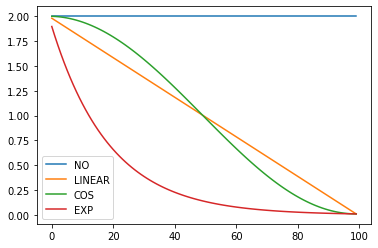

In [16]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1, 100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [17]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [20]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

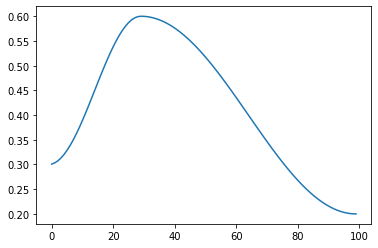

In [21]:
plt.plot(a, [sched(o) for o in p])

In [27]:
cbfs = [Recorder,
       partial(AvgStatsCallback,accuracy),
       partial(ParamScheduler, 'lr', sched)]

In [28]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [29]:
run.fit(3, learn)

train: [0.7806971875, tensor(0.7817)]
valid: [0.3276677734375, tensor(0.9033)]
train: [0.3087511328125, tensor(0.9088)]
valid: [0.2452677001953125, tensor(0.9280)]
train: [0.246496953125, tensor(0.9289)]
valid: [0.2201901611328125, tensor(0.9373)]


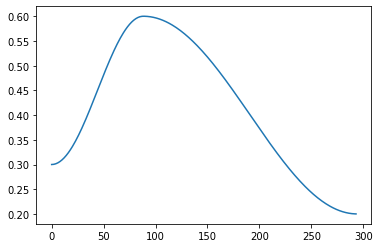

In [30]:
run.recorder.plot_lr()

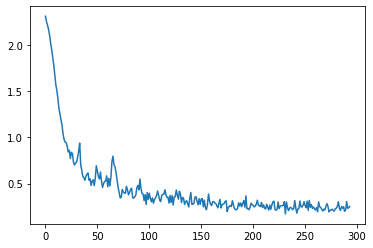

In [31]:
run.recorder.plot_loss()

In [32]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
